In [39]:
import os
import json
import uuid
from IPython.display import display, Image
from typing import TypedDict, Annotated, Optional, Literal, Any, List, AsyncGenerator

from langgraph.checkpoint.postgres.aio import AsyncPostgresSaver
from langgraph.graph.state import CompiledStateGraph
from openai.resources.containers.files import content
from psycopg_pool import AsyncConnectionPool
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from langgraph.graph import add_messages
from langgraph.types import interrupt, Command
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate

from agents.guidance import build_graph
from dto.response.grades import GradeResponseBase
from dto.response.matrix_chats import MessageDict

load_dotenv()
db_url = os.getenv("PG_VECTOR_DATABASE_URL")

LITE_LLM_API_KEY = os.getenv("OPENAI_API_KEY")
# LITE_LLM_URL = os.getenv("OPENAI_BASE_URL")
# LITE_MODEL = os.getenv("OPENAI_MODEL")

# model = ChatOpenAI(model=LITE_MODEL, api_key=LITE_LLM_API_KEY, base_url=LITE_LLM_URL)
model = ChatOpenAI(
    model="gpt-4o", api_key=LITE_LLM_API_KEY, streaming=True, verbose=True
)


class AmbiguousStdOutput(BaseModel):
    is_ambiguous: bool
    question: str


class FinalClassificationStdOutput(BaseModel):
    final_class: str = Field(description="Final classification label")
    final_class_id: int = Field(description="Id of the final classification")
    message_to_the_user: str = Field(description="Message to user")


class SpellcheckBase(BaseModel):
    spelling: str
    corrected_spelling: str
    correction_applied: bool


class ReasonerOutputBase(BaseModel):
    classification: str
    classification_explanation: str
    certainty_level: int


class ReasonerState(TypedDict):
    grades: List[GradeResponseBase]
    messages: Annotated[list, add_messages]
    spellcheck_response: Optional[SpellcheckBase]
    reasoner_response: Optional[ReasonerOutputBase]
    interrupt_state: dict[str, str]
    is_ambiguous: bool
    ambiguous_output: Optional[str]
    number_of_irregularities: Optional[int]
    final_result: Optional[FinalClassificationStdOutput]


class ClassifierState(TypedDict):
    grades: List[GradeResponseBase]
    msgs: Annotated[list, add_messages]
    finished_state: Optional[str]
    interrupt_state: dict[str, str]


classifier_builder = StateGraph(ClassifierState)


async def reasoner(state: ClassifierState) -> ClassifierState:
    message = ChatPromptTemplate.from_messages(
        (
            "system",
            """
            Based on the user question you need to categorize into one of the following categories:
            {categories}
            Respond only with the category recognized!
            """,
        )
    )
    msg = message.format(categories=state["grades"])
    model_structured = model.with_structured_output(ReasonerOutputBase)
    response = await model_structured.ainvoke(state["msgs"] + [msg])
    return {
        "msgs": [AIMessage(response.classification)],
        "finished_state": None,
        "grades": state["grades"],
        "interrupt_state": {},
    }


async def reflect(state: ClassifierState) -> ClassifierState:
    input_val = state["msgs"][-2].content
    predicted_state = state["msgs"][-1].content
    prompt_template = ChatPromptTemplate.from_template(
        """
        You are an reviewing user submission categorization of the answer of expertise in a particular subject.
        You are provided the available expertise categories to which you need to categorize into.
        Critique the prediction if you think it's incorrect!
        If you agree with correct prediction respond with exactly "finish" without any explanations!
        If you find the categorization inconclusive or not indicative in any way of the user message respond with exactly "human"!
        Expertise categories:
        {categories}
        Users message: {msg}
        Predicted user expertise: {state}
        """
    )
    prompt = await prompt_template.ainvoke(
        {"state": predicted_state, "msg": input_val, "categories": state["grades"]}
    )
    response = model.invoke(prompt)
    print("REFLECT RESPONSE", response)
    return {
        "msgs": [HumanMessage(response.content)],
        "finished_state": None,
        "grades": state["grades"],
        "interrupt_state": {},
    }


async def correct_found(
    state: ClassifierState,
) -> Literal["reasoner", "human", "finish"]:
    if state["msgs"][-1].content == "finish":
        print("CORRECT RESPONSE finish")
        return "finish"
    elif state["msgs"][-1].content == "human":
        print("CORRECT RESPONSE human")
        return "human"
    print("CORRECT RESPONSE reasoner")
    return "reasoner"


async def finish(state: ClassifierState) -> ClassifierState:
    finished_state = state["msgs"][-2].content
    return {
        "msgs": state["msgs"],
        "finished_state": finished_state,
        "grades": state["grades"],
        "interrupt_state": {},
    }


async def human(state: ClassifierState) -> ClassifierState:
    interrupt_val = {
        "answer_to_revisit": state["msgs"][-2].content,
    }
    value = interrupt(
        interrupt_val,
    )
    print("HUMAN IN THE LOOP RESPONSE")
    return {
        "msgs": [AIMessage(value)],
        "finished_state": state["finished_state"],
        "grades": state["grades"],
        "interrupt_state": interrupt_val,
    }


classifier_builder.add_node("reasoner", reasoner)
classifier_builder.add_node("reflect", reflect)
classifier_builder.add_node("finish", finish)
classifier_builder.add_node("human", human)
classifier_builder.add_edge(START, "reasoner")
classifier_builder.add_edge("reasoner", "reflect")
classifier_builder.add_conditional_edges("reflect", correct_found)
classifier_builder.add_edge("reflect", "finish")
classifier_builder.add_edge("human", "finish")
classifier_builder.add_edge("finish", END)

classify = classifier_builder.compile()

builder = StateGraph(ReasonerState)


async def answer_classifier(state: ReasonerState) -> ReasonerState:
    guidance_graph = await build_graph()
    display(Image(guidance_graph.get_graph().draw_mermaid_png()))
    irregularities_num = 0
    if "number_of_irregularities" in state:
        if state["number_of_irregularities"] is None:
            irregularities_num = 0
    response = await guidance_graph.ainvoke(
        {
            "question": state["messages"][-2].content,
            "answer": state["messages"][-1].content,
            "irregularity_amount": irregularities_num,
        }
    )
    message_to_respond = []
    if len(response["messages"]) > 0:
        message_to_respond = [response["messages"][-1]]

    print("ANSWER CATEGORIZATION", response)
    return {
        "grades": state["grades"],
        "messages": message_to_respond,
        "number_of_irregularities": irregularities_num,
        "spellcheck_response": None,
        "reasoner_response": None,
        "interrupt_state": {},
        "is_ambiguous": False,
        "ambiguous_output": response["classification"],
        "final_result": None,
    }


async def ambiguity_resolver(state: ReasonerState) -> ReasonerState:
    message = ChatPromptTemplate.from_messages(
        (
            "system",
            """
            You are responsible to understand is there any ambiguity in answer from the user?
            User was asked to provide an answer about their expertise in the categories.
            Check whether one of the answers corresponds to the categories provided. It does not have to be in the same
            wording!
            If the answer is ambiguous (not related to any category) please respond that this is not related with the question
            and reiterate the question

            Categories: {categories}
            Answer: {answer}
            """,
        )
    )
    print("AMBIGUOUS RESOLVER IN STATE", state)
    structured_output_model = model.with_structured_output(AmbiguousStdOutput)
    msg = message.format(
        categories=state["grades"], answer=state["messages"][-1].content
    )
    response = await structured_output_model.ainvoke(
        state["messages"] + [AIMessage(msg)]
    )
    return {
        "grades": state["grades"],
        "messages": [AIMessage(response.question)],
        "spellcheck_response": response,
        "reasoner_response": None,
        "interrupt_state": {},
        "is_ambiguous": response.is_ambiguous,
        "ambiguous_output": response.question,
        "number_of_irregularities": state["number_of_irregularities"],
        "final_result": None,
    }


async def next_step(
    state: ReasonerState,
) -> Literal["deeply_classify", "ask_clarification"]:
    if state["ambiguous_output"] != "direct":
        return "ask_clarification"
    return "deeply_classify"


async def ask_clarification(state: ReasonerState) -> ReasonerState:
    interrupt_val = {
        "answer_to_revisit": state["messages"][-2].content,
    }
    interrupt_msg = interrupt(interrupt_val)
    return {
        "grades": state["grades"],
        "messages": [AIMessage(interrupt_msg)],
        "spellcheck_response": state["spellcheck_response"],
        "reasoner_response": None,
        "interrupt_state": interrupt_val,
        "is_ambiguous": state["is_ambiguous"],
        "ambiguous_output": state["ambiguous_output"],
        "number_of_irregularities": state["number_of_irregularities"],
        "final_result": None,
    }


async def deeply_classify(state: ReasonerState) -> ReasonerState:
    async for class_chunk in classify.astream(
        {"msgs": state["messages"], "finished_state": None, "grades": state["grades"]}
    ):
        if (
            "finished_state" in class_chunk
            and class_chunk["finished_state"] is not None
        ):
            msg = class_chunk["finished_state"]
    return {
        "grades": state["grades"],
        "messages": [],
        "spellcheck_response": state["spellcheck_response"],
        "reasoner_response": state["reasoner_response"],
        "interrupt_state": {},
        "is_ambiguous": state["is_ambiguous"],
        "ambiguous_output": state["ambiguous_output"],
        "number_of_irregularities": state["number_of_irregularities"],
        "final_result": None,
    }


async def reasoner(state: ReasonerState) -> ReasonerState:
    prompt_template = ChatPromptTemplate.from_template(
        """
        Summarize the conversation and thank the user and show the finalized categorization emphasized!
        Use one of these categories, labels only, do not display the entire object:
        {grades}
        Do not explain yourself and prolong the conversation!
        """
    )
    prompt = prompt_template.invoke({"grades": state["grades"]})
    structured_output_model = model.with_structured_output(FinalClassificationStdOutput)
    response = structured_output_model.invoke(
        state["messages"] + [HumanMessage(prompt.to_string())]
    )
    print("REASONER RESPONSE -> ", response)
    return {
        "grades": state["grades"],
        "messages": [],
        "spellcheck_response": state["spellcheck_response"],
        "reasoner_response": state["reasoner_response"],
        "interrupt_state": {},
        "is_ambiguous": state["is_ambiguous"],
        "ambiguous_output": state["ambiguous_output"],
        "number_of_irregularities": state["number_of_irregularities"],
        "final_result": response,
    }


async def human(state: ReasonerState) -> ReasonerState:
    print("HUMAN REASONER")
    return {
        "grades": state["grades"],
        "messages": [],
        "spellcheck_response": state["spellcheck_response"],
        "reasoner_response": state["reasoner_response"],
        "interrupt_state": {},
        "is_ambiguous": state["is_ambiguous"],
        "ambiguous_output": state["ambiguous_output"],
        "number_of_irregularities": state["number_of_irregularities"],
        "final_result": state["final_result"],
    }


builder.add_node("answer_classifier", answer_classifier)
builder.add_node("ask_clarification", ask_clarification)
builder.add_node("deeply_classify", deeply_classify)
builder.add_node("reasoner", reasoner)
builder.add_edge(START, "answer_classifier")
builder.add_conditional_edges("answer_classifier", next_step)
builder.add_edge("ask_clarification", "deeply_classify")
builder.add_edge("deeply_classify", "reasoner")
builder.add_edge("reasoner", END)

full_graph = builder.compile()


async def get_graph() -> AsyncGenerator[CompiledStateGraph, Any]:
    async with AsyncConnectionPool(db_url) as conn:
        checkpointer = AsyncPostgresSaver(
            conn=conn,
        )
        graph = builder.compile(checkpointer=checkpointer)
        yield graph


async def reasoner_run(
    thread_id: uuid.UUID, msgs: List[MessageDict], grades: List[GradeResponseBase]
) -> AsyncGenerator[str, Any]:
    async for graph in get_graph():
        config = {"configurable": {"thread_id": thread_id}}

        async for chunk in graph.astream(
            {
                "messages": msgs,
                "grades": grades,
            },
            config,
        ):
            print("async chunk", chunk)
            interrupt_happened = False
            interrupt_value = ""
            processing_type = ""
            actual_type = list(chunk.keys())[0]
            message_val = ""
            print("ACTUAL TYPE", actual_type)
            if actual_type == "answer_classifier":
                processing_type = "Classifying answer"
            elif actual_type == "ambiguity":
                processing_type = "Resolving ambiguity"
            elif actual_type == "__interrupt__":
                processing_type = "Interrupt"
            elif actual_type == "deeply_classify":
                processing_type = "Classifying"
            elif actual_type == "reasoner":
                processing_type = "Finalizing"
            print("PROCESSING TYPE", processing_type)
            if "__interrupt__" in chunk:
                interrupt_happened = True
                interrupt_value = chunk["__interrupt__"][0].value["answer_to_revisit"]
                message_val = chunk["__interrupt__"][0].value["answer_to_revisit"]
            else:
                if "final_result" in chunk[actual_type] is not None:
                    if hasattr(chunk[actual_type]["final_result"], "message_to_the_user"):
                        message_val = chunk[actual_type]["final_result"].message_to_the_user
                if len(chunk[actual_type]["messages"]) > 0:
                    print("WHY DO MESSAGES NEVER GO IN")
                    message_val = chunk[actual_type]["messages"][-1].content


            yield json.dumps(
                {
                    "type": processing_type,
                    "interrupt_happened": interrupt_happened,
                    "interrupt_value": interrupt_value,
                    "message": message_val,
                    "final_result": (
                        chunk[actual_type]["final_result"].final_class
                        if "final_result" in chunk[actual_type]
                        and isinstance(
                            chunk[actual_type]["final_result"],
                            FinalClassificationStdOutput,
                        )
                        else ""
                    ),
                }
            )


async def run_interrupted(thread_id: uuid.UUID, unblock_value: str):
    async for graph in get_graph():
        config = {"configurable": {"thread_id": thread_id}}
        state = await graph.aget_state(config)
        unblock_response = await graph.ainvoke(
            Command(resume=unblock_value), config=config
        )


STARTING TESTING
THREAD ID: 1c3a4743-98ac-4dfb-83cd-41b5a3988c82


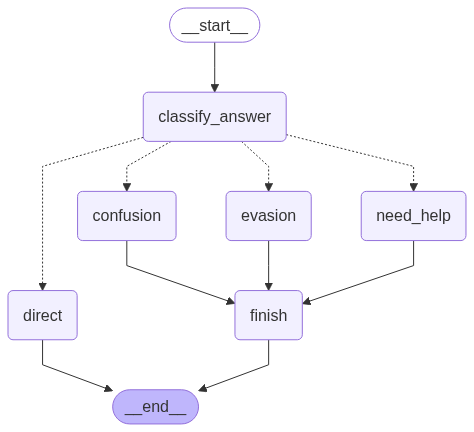

CLASSIFY ANSWER ANSWER evasion
EVASION
EVASION ANSWER It seems like the answer provided doesn't directly address the question or concern. It's important to engage in meaningful and relevant communication to maintain the quality of the discussion. If there's anything unclear or if further information is needed, please don't hesitate to ask for clarification.

Continued non-engagement with the questions or topic may lead to escalation to higher management for resolution. We value productive conversations, and your cooperation in maintaining focus is appreciated. Let's aim for clear and constructive dialogue to achieve our objectives.
ANSWER CATEGORIZATION {'question': "\n        It seems like the response provided doesn't address the question or contribute meaningfully to the discussion.It's important to provide relevant and thoughtful answers to ensure productive communication. If there are any concerns or confusion about the topic, please feel free to ask for clarification or more info

In [47]:
from utils.common import convert_msg_dict_to_langgraph_format
import asyncio

grades: List[GradeResponseBase] = [
    GradeResponseBase(
        id=1,
        label="Not Informed",
        value=1
    ),
    GradeResponseBase(
        id=2,
        label="Informed Basics",
        value=2
    ),
    GradeResponseBase(
        id=3,
        label="Informed in Details",
        value=3
    ),
    GradeResponseBase(
        id=4,
        label="Practice and Lab Examples",
        value=4
    ),
    GradeResponseBase(
        id=5,
        label="Production Maintenance",
        value=5
    ),
    GradeResponseBase(
        id=6,
        label="Production from Scratch",
        value=6
    ),
    GradeResponseBase(
        id=7,
        label="Educator/Expert",
        value=7
    ),
]

msgs: List[MessageDict] = [
    MessageDict(
        msg_type="ai",
        message="""
        Expertise in Cryptography
        Welcome, Jessica! In this discussion, we will explore your expertise in Cryptography, which focuses on implementing encryption, hashing, and secure communication protocols. Understanding the appropriate expertise level is crucial for your learning and application in the field.

        We offer various expertise grades to help you identify where you stand or where you want to grow:

        Not Informed - Basic understanding of the subject.
        Informed Basics - Familiarity with fundamental concepts.
        Informed in Details - Comprehensive knowledge of the topic.
        Practice and Lab Examples - Practical experience and demonstration.
        Production Maintenance - Hands-on experience in maintaining production systems.
        Production from Scratch - Ability to build production systems from the ground up.
        Educator/Expert - Mastery of the subject, capable of teaching others.
        Select the expertise level that resonates with your current understanding or desired growth in Cryptography, and let’s enhance your skills!
        """
    ),
    MessageDict(
        msg_type="human",
        message="""
        bla bla bla
        """
    ),
    MessageDict(
        msg_type="ai",
        message="""
        It seems like the response provided doesn't address the question or contribute meaningfully to the discussion.It's important to provide relevant and thoughtful answers to ensure productive communication. If there are any concerns or confusion about the topic, please feel free to ask for clarification or more information.

If this pattern of providing unrelated answers continues, we may need to escalate the matter to managers for further assistance. Your cooperation is appreciated as we strive to make this discussion beneficial for everyone involved. Let's work together to ensure the conversation stays focused and effective.
        """
    ),
    MessageDict(
        msg_type="human",
        message="""
        Working great
        """
    ),
]

messages_to_send = convert_msg_dict_to_langgraph_format(msgs)

def completed_task(result):
    print("COMPLETED TASK:", result.result())

async def main():
    # Get the current running loop
    loop = asyncio.get_running_loop()
    thread_id = uuid.uuid4()
    print("STARTING TESTING")
    print("THREAD ID:", thread_id)
    async for result in reasoner_run(thread_id, messages_to_send, grades):
        yield result

async for result in main():
    print("RESULT:", result)

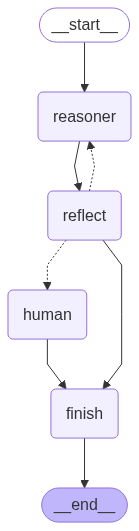

In [48]:
display(Image(classify.get_graph().draw_mermaid_png()))

In [46]:
for classify_chunk in await classify.ainvoke(
        {
            "msgs": [msg.message for msg in msgs],
            "grades": grades,
        }
):
    print("CHUNK", classify_chunk)

REFLECT RESPONSE content='human' additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'service_tier': 'default'} id='run--10dda673-1851-4cdd-9f59-0f68e9054ad1-0'
CORRECT RESPONSE human
CHUNK grades
CHUNK msgs
CHUNK finished_state
CHUNK interrupt_state
CHUNK __interrupt__


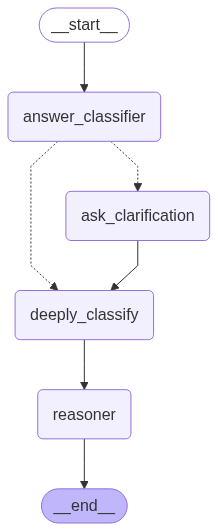

In [27]:
display(Image(full_graph.get_graph().draw_mermaid_png()))
